# Population Branch Statistics (PBS)

In [1]:
%run "imports.ipynb"

In [2]:
ac_biallel = zarr.open('data/phase2_biallel_allele_count.zarr')
outgroup_allele_counts= zarr.open('data/outgroup_alleles_phase2.zarr')
callset = callset_biallel

In [3]:
contigs = ['2R','2L','3R','3L', 'X']

----------------------------------------------

In [4]:
def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = allel.AlleleCountsArray(ac_biallel[chrom][pop1])
    ac2 = allel.AlleleCountsArray(ac_biallel[chrom][pop2])
    ac3 = allel.AlleleCountsArray(outgroup_allele_counts[chrom][pop3])

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res

def pbs_plot (chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    starts, ends, y = pbs(chrom, pop1, pop2, pop3)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = (starts + ends) / 2
    sns.despine(ax=ax, offset=10)
    ax.set_xlim(0, x.max())
    ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Genome position (bp)')
    ax.set_ylabel('PBS');
    


def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=90, height=0.5)
    
    
    
    
def locate_genes(chrom, value, pop1, pop2, pop3):    
    col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                             sep='\t', comment='#', low_memory=False,
                             header=None, names=col_names)
   
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > value]
    
    df2 = pd.DataFrame([])
    for i in range(len(over30)):
        a=(df[(df.seqid == chrom) & (df.type == 'gene') & (df['start'] <= over30[i]-100) & (df['end'] >= over30[i]+100)])
        
        df2 = df2.append(a)
        df2.drop_duplicates(keep=False,inplace=True)

    log('Found', len(over30), 'SNPs with PBS values above', value, '\n', 'Total genes found:', len(df2))

    return df2




def plot_genes_pbs(chrom, pop1, pop2, pop3):
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.2]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])

## PBS by sympatric populations using <i>An.christyi</i> population as outgroup

### Chromosome 3R

/opt/conda/lib/python3.6/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


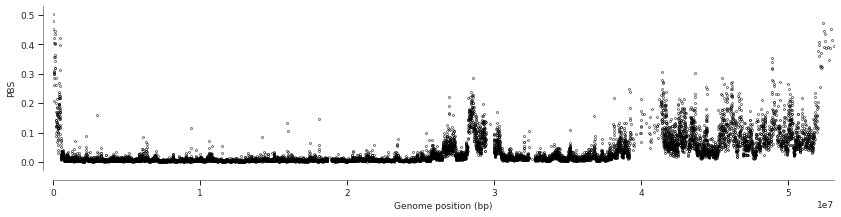

In [5]:
pbs_plot('3R', 'BFcol', 'BFgam', 'chri')

In [6]:
locate_genes('3R', 0.4, 'BFcol', 'BFgam', 'chri')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 16 SNPs with PBS values above 0.4 
 Total genes found: 4


,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
155349,3R,VectorBase,gene,52067738,52115209,.,+,.,ID=AGAP010286;biotype=protein_coding
155628,3R,VectorBase,gene,52851999,52854757,.,-,.,ID=AGAP010302;biotype=protein_coding
155636,3R,VectorBase,gene,52903957,52937651,.,-,.,ID=AGAP010303;biotype=protein_coding


/opt/conda/lib/python3.6/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


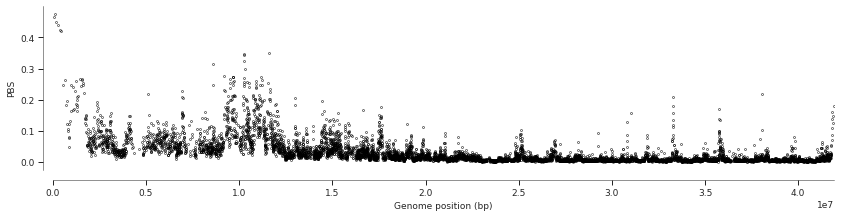

In [5]:
pbs_plot('3L', 'BFcol', 'BFgam', 'chri')

In [7]:
locate_genes('3L', 0.4, 'BFcol', 'BFgam', 'chri')

Found 6 SNPs with PBS values above 0.4 
 Total genes found: 3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes
95782,3L,VectorBase,gene,168567,195705,.,-,.,ID=AGAP010312;biotype=protein_coding
95823,3L,VectorBase,gene,356758,377200,.,+,.,ID=AGAP010314;biotype=protein_coding
95832,3L,VectorBase,gene,377201,388139,.,-,.,ID=AGAP010315;biotype=protein_coding


------------------------------

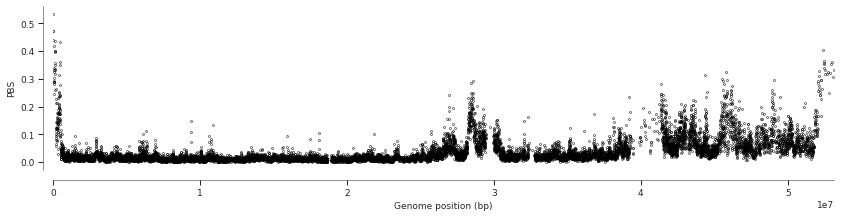

In [8]:
pbs_plot('3R', 'GHcol', 'GHgam', 'chri')

In [9]:
locate_genes('3R', 0.4, 'GHcol', 'GHgam', 'chri')

Found 10 SNPs with PBS values above 0.4 
 Total genes found: 2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding


In [15]:
gh = locate_genes('3R', 0.3, 'GHcol', 'GHgam', 'chri')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 40 SNPs with PBS values above 0.3 
 Total genes found: 8


-------------------

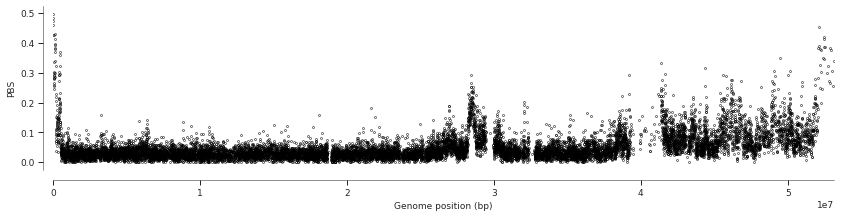

In [11]:
pbs_plot('3R', 'GNcol', 'GNgam', 'chri')

In [12]:
locate_genes('3R', 0.4, 'GNcol', 'GNgam', 'chri')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 11 SNPs with PBS values above 0.4 
 Total genes found: 3


,seqid,source,type,start,end,score,strand,phase,attributes
119834,3R,VectorBase,gene,24056,39486,.,+,.,ID=AGAP007732;biotype=protein_coding
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
155349,3R,VectorBase,gene,52067738,52115209,.,+,.,ID=AGAP010286;biotype=protein_coding


In [14]:
gn = locate_genes('3R', 0.3, 'GNcol', 'GNgam', 'chri')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 45 SNPs with PBS values above 0.3 
 Total genes found: 9


--------------------

In [17]:
gn

,seqid,source,type,start,end,score,strand,phase,attributes
119834,3R,VectorBase,gene,24056,39486,.,+,.,ID=AGAP007732;biotype=protein_coding
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119957,3R,VectorBase,gene,176320,179405,.,+,.,ID=AGAP007742;biotype=protein_coding
152692,3R,VectorBase,gene,49458955,49484075,.,+,.,ID=AGAP010147;biotype=protein_coding
155472,3R,VectorBase,gene,52237449,52248062,.,+,.,ID=AGAP010290;biotype=protein_coding
155554,3R,VectorBase,gene,52457332,52554377,.,-,.,ID=AGAP010295;biotype=protein_coding
155602,3R,VectorBase,gene,52655670,52657280,.,+,.,ID=AGAP010298;biotype=protein_coding
155636,3R,VectorBase,gene,52903957,52937651,.,-,.,ID=AGAP010303;biotype=protein_coding
155705,3R,VectorBase,gene,53071753,53087640,.,-,.,ID=AGAP010307;biotype=protein_coding


In [18]:
gh 

,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119939,3R,VectorBase,gene,172973,173928,.,+,.,ID=AGAP007740;biotype=protein_coding
120235,3R,VectorBase,gene,461780,478211,.,-,.,ID=AGAP007761;biotype=protein_coding
120251,3R,VectorBase,gene,466370,468350,.,+,.,ID=AGAP007762;biotype=protein_coding
150130,3R,VectorBase,gene,45808083,45809514,.,+,.,ID=AGAP009945;biotype=protein_coding
155544,3R,VectorBase,gene,52418651,52422892,.,-,.,ID=AGAP010294;biotype=protein_coding
155659,3R,VectorBase,gene,52951761,52996140,.,+,.,ID=AGAP010304;biotype=protein_coding
155705,3R,VectorBase,gene,53071753,53087640,.,-,.,ID=AGAP010307;biotype=protein_coding


In [19]:
bf

,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
119921,3R,VectorBase,gene,166770,169081,.,+,.,ID=AGAP007738;biotype=protein_coding
120235,3R,VectorBase,gene,461780,478211,.,-,.,ID=AGAP007761;biotype=protein_coding
120251,3R,VectorBase,gene,466370,468350,.,+,.,ID=AGAP007762;biotype=protein_coding
148473,3R,VectorBase,gene,43676455,43697706,.,-,.,ID=AGAP009805;biotype=protein_coding
155330,3R,VectorBase,gene,52042711,52059885,.,+,.,ID=AGAP010283;biotype=protein_coding
155472,3R,VectorBase,gene,52237449,52248062,.,+,.,ID=AGAP010290;biotype=protein_coding
155489,3R,VectorBase,gene,52266283,52270108,.,-,.,ID=AGAP010291;biotype=protein_coding
155544,3R,VectorBase,gene,52418651,52422892,.,-,.,ID=AGAP010294;biotype=protein_coding


In [21]:
tbl1 = pd.merge(gh, gn, on='attributes', how='inner')
tbl1

,seqid_x,source_x,type_x,start_x,end_x,score_x,strand_x,phase_x,attributes,seqid_y,source_y,type_y,start_y,end_y,score_y,strand_y,phase_y
0,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding,3R,VectorBase,gene,57849,62977,.,+,.
1,3R,VectorBase,gene,53071753,53087640,.,-,.,ID=AGAP010307;biotype=protein_coding,3R,VectorBase,gene,53071753,53087640,.,-,.


In [22]:
tbl2 = pd.merge(tbl1, bf, on='attributes', how='inner')

In [23]:
tbl2

,seqid_x,source_x,type_x,start_x,end_x,score_x,strand_x,phase_x,attributes,seqid_y,...,strand_y,phase_y,seqid,source,type,start,end,score,strand,phase
0,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding,3R,...,+,.,3R,VectorBase,gene,57849,62977,.,+,.


--------------------------------

/opt/conda/lib/python3.6/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


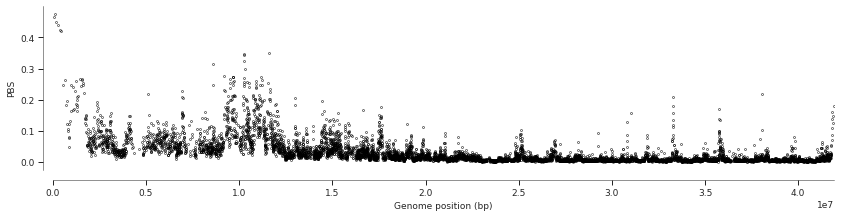

In [5]:
pbs_plot('3L', 'BFcol', 'BFgam', 'chri')

In [7]:
locate_genes('3L', 0.4, 'BFcol', 'BFgam', 'chri')

Found 6 SNPs with PBS values above 0.4 
 Total genes found: 3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes
95782,3L,VectorBase,gene,168567,195705,.,-,.,ID=AGAP010312;biotype=protein_coding
95823,3L,VectorBase,gene,356758,377200,.,+,.,ID=AGAP010314;biotype=protein_coding
95832,3L,VectorBase,gene,377201,388139,.,-,.,ID=AGAP010315;biotype=protein_coding
